In [1]:
from sentiment import utils


DATASET_DIR = './goemotions_data/'
classes = utils.load_classes(DATASET_DIR)
classes.remove('neutral')
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise']

In [2]:
%%time
train_df, val_df, test_df = utils.make_dataframes(DATASET_DIR,
                                                  fraction=0.8,
                                                  random=1681944339,
                                                  split_by_class=True,
                                                  drop_neutral=True,
                                                  test_only_singles=True,
                                                  oversample_low=True,
                                                  low_threshold=500)

Random seed: 1682369361
CPU times: total: 938 ms
Wall time: 950 ms


D:\sentiment-analysis\sentiment\utils.py:116: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (df['labels'].str.contains(f'(^|,){label}(,|$)',


D:\sentiment-analysis\sentiment\utils.py:568: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


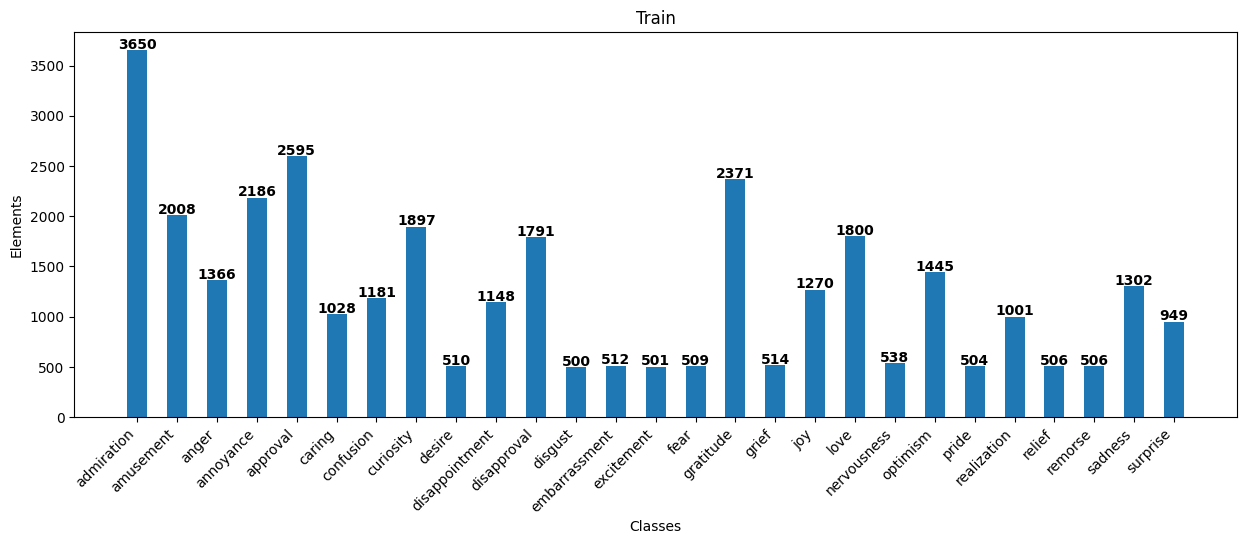

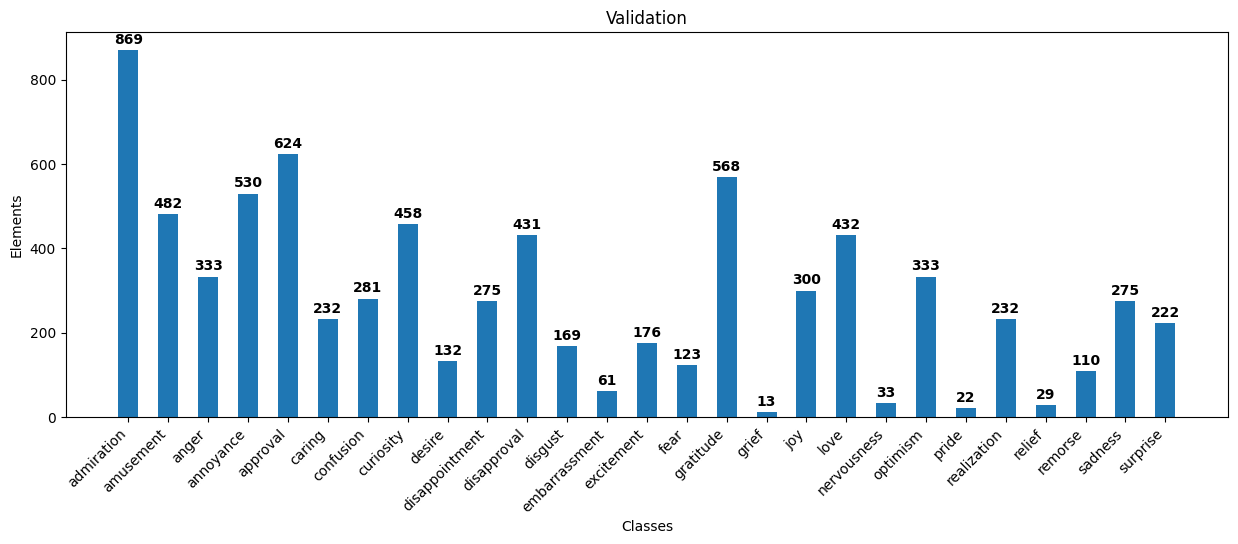

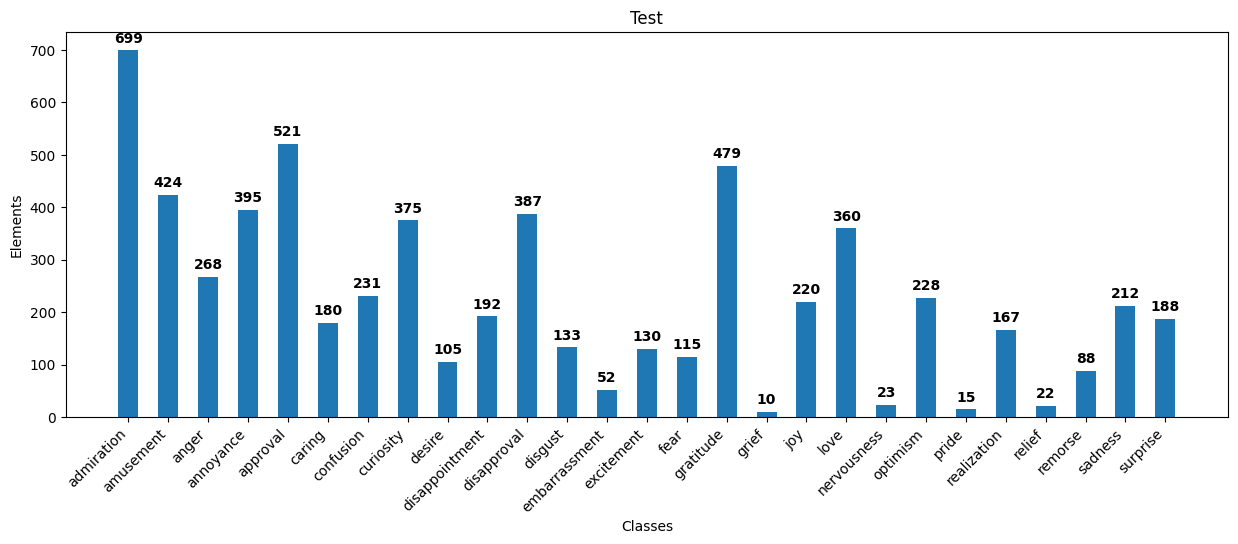

In [3]:
from tensorflow.data import AUTOTUNE

BATCH_SIZE = 64


dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    utils.plot_class_distr(df, classes, title)
train_ds = utils.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = utils.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = utils.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from sentiment import standardize

VOCAB_SIZE = 40_000

standardizer = standardize.TextStandardizeLayer()
encoder = TextVectorization(max_tokens=VOCAB_SIZE,
                            standardize=standardizer.call,
                            split='whitespace',
                            pad_to_max_tokens=True,
                            ngrams=(1, 2),
                            output_mode='tf_idf')
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['[UNK]', 'i', 'the', 'is', 'to', 'a', 'you', 'it', 'that', 'and',
       'not', 'of', 'this', 'for', 'in', 'are', 'have', 'am', 'my',
       'i am'], dtype='<U32')

In [5]:
from tensorflow.keras import Input
from tensorflow.keras.layers import (Dropout, Dense)
from tensorflow.keras import Sequential

model = Sequential([
    encoder,
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='sigmoid'),
])

In [6]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


THRESHOLD = 0.5
EPOCHS = 20
INIT_LR = 1e-4


optimizer = Adam(INIT_LR)
metrics = utils.create_metrics(classes, THRESHOLD)
loss = BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping


history = model.fit(x=train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/20
423/423 [==============================] - 88s 194ms/step - loss: 0.3062 - precision@0.5/admiration: 0.1835 - recall@0.5/admiration: 0.0378 - precision@0.5/amusement: 0.1408 - recall@0.5/amusement: 0.0448 - precision@0.5/anger: 0.0366 - recall@0.5/anger: 0.0117 - precision@0.5/annoyance: 0.1041 - recall@0.5/annoyance: 0.0384 - precision@0.5/approval: 0.1193 - recall@0.5/approval: 0.0274 - precision@0.5/caring: 0.0305 - recall@0.5/caring: 0.0195 - precision@0.5/confusion: 0.0509 - recall@0.5/confusion: 0.0161 - precision@0.5/curiosity: 0.0738 - recall@0.5/curiosity: 0.0569 - precision@0.5/desire: 0.0200 - recall@0.5/desire: 0.0373 - precision@0.5/disappointment: 0.0217 - recall@0.5/disappointment: 0.0052 - precision@0.5/disapproval: 0.0662 - recall@0.5/disapproval: 0.0145 - precision@0.5/disgust: 0.0220 - recall@0.5/disgust: 0.0820 - precision@0.5/embarrassment: 0.0354 - recall@0.5/embarrassment: 0.0801 - precision@0.5/excitement: 0.0152 - recall@0.5/excitement: 0.0399 - prec

In [8]:
eval_metrics = model.evaluate(x=test_ds, return_dict=True)
utils.print_metrics(eval_metrics)

98/98 [==============================] - 4s 42ms/step - loss: 0.1025 - precision@0.5/admiration: 0.7160 - recall@0.5/admiration: 0.5265 - precision@0.5/amusement: 0.8304 - recall@0.5/amusement: 0.4387 - precision@0.5/anger: 0.6778 - recall@0.5/anger: 0.2276 - precision@0.5/annoyance: 0.2736 - recall@0.5/annoyance: 0.0734 - precision@0.5/approval: 0.4110 - recall@0.5/approval: 0.1727 - precision@0.5/caring: 0.6479 - recall@0.5/caring: 0.2556 - precision@0.5/confusion: 0.6463 - recall@0.5/confusion: 0.2294 - precision@0.5/curiosity: 0.6211 - recall@0.5/curiosity: 0.3147 - precision@0.5/desire: 0.7200 - recall@0.5/desire: 0.1714 - precision@0.5/disappointment: 0.3750 - recall@0.5/disappointment: 0.0312 - precision@0.5/disapproval: 0.5172 - recall@0.5/disapproval: 0.1938 - precision@0.5/disgust: 0.8750 - recall@0.5/disgust: 0.0526 - precision@0.5/embarrassment: 1.0000 - recall@0.5/embarrassment: 0.0192 - precision@0.5/excitement: 0.9091 - recall@0.5/excitement: 0.0769 - precision@0.5/fear:

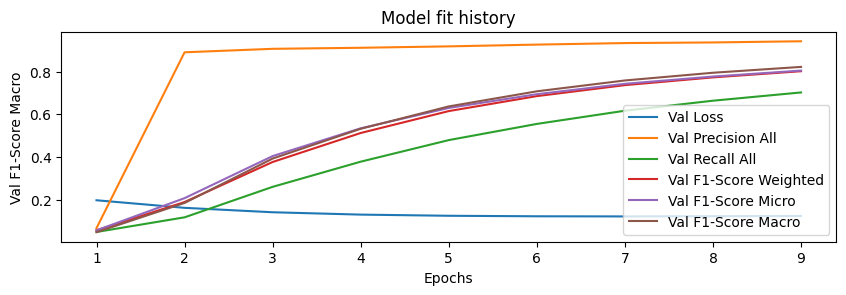

In [9]:
stats = history.history
stats_plots = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score Weighted': stats['f1_score@0.5/all'],
    'Val F1-Score Micro': stats['f1_score_micro@0.5/all'],
    'Val F1-Score Macro': stats['f1_score_macro@0.5/all'],
}
utils.plot_history(stats_plots)

## Score test and run most-important metrics on emotions prediction

In [10]:
from tensorflow.keras.metrics import Precision
from tensorflow_addons.metrics import F1Score


test_metrics = {
    'TP Rate (precision)': Precision(),
    'F1-Score (micro)': F1Score(num_classes=len(classes), threshold=THRESHOLD, average='micro'),
    'F1-Score (macro)': F1Score(num_classes=len(classes), threshold=THRESHOLD, average='macro'),
}
utils.score_test(test_ds, model, test_metrics.values(), THRESHOLD)
for name, metric in test_metrics.items():
    print('{}: {:.4f}'.format(name, metric.result().numpy()))

TP Rate (precision): 0.6944
F1-Score (micro): 0.4361
F1-Score (macro): 0.3023


## Score test and run most-important metrics on sentiments prediction

In [11]:
sentiments = utils.load_sentiments(DATASET_DIR)
sentiment_map = utils.map_sentiments(classes, sentiments)
del sentiment_map[27]
test_metrics = {
    'TP Rate (precision)': Precision(),
    'F1-Score (micro)': F1Score(num_classes=len(sentiments), threshold=THRESHOLD, average='micro'),
    'F1-Score (macro)': F1Score(num_classes=len(sentiments), threshold=THRESHOLD, average='macro'),
}
utils.score_test(test_ds, model, test_metrics.values(),
                           THRESHOLD, sentiment_map)
for name, metric in test_metrics.items():
    print('{}: {:.4f}'.format(name, metric.result().numpy()))

TP Rate (precision): 0.8748
F1-Score (micro): 0.5318
F1-Score (macro): 0.4647


In [12]:
utils.test_examples(model, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
I have performed well at the university: 
The war has started: 
He is desperate in this cruel world: 
I love the feeling when my girlfriend hugs me: love ❤️
I hate monday mornings: 
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : 
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): gratitude 🙏
I have the new pan for pancakes.: 
Relax, bro. Take it easy: 
WTF? Are they kidding us? I'm gonna argue with the manager!: curiosity 🤔
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
I am so glad this is over: joy 😃
Sorry, I feel bad for having said that: sadness 😞
Happy birthday, my friend! I wish you a lot of success!: optimism 🤞
What a shame! I will never talk to him: 
What if she knows? We don't know what to do: confusion 😕 curiosity 🤔

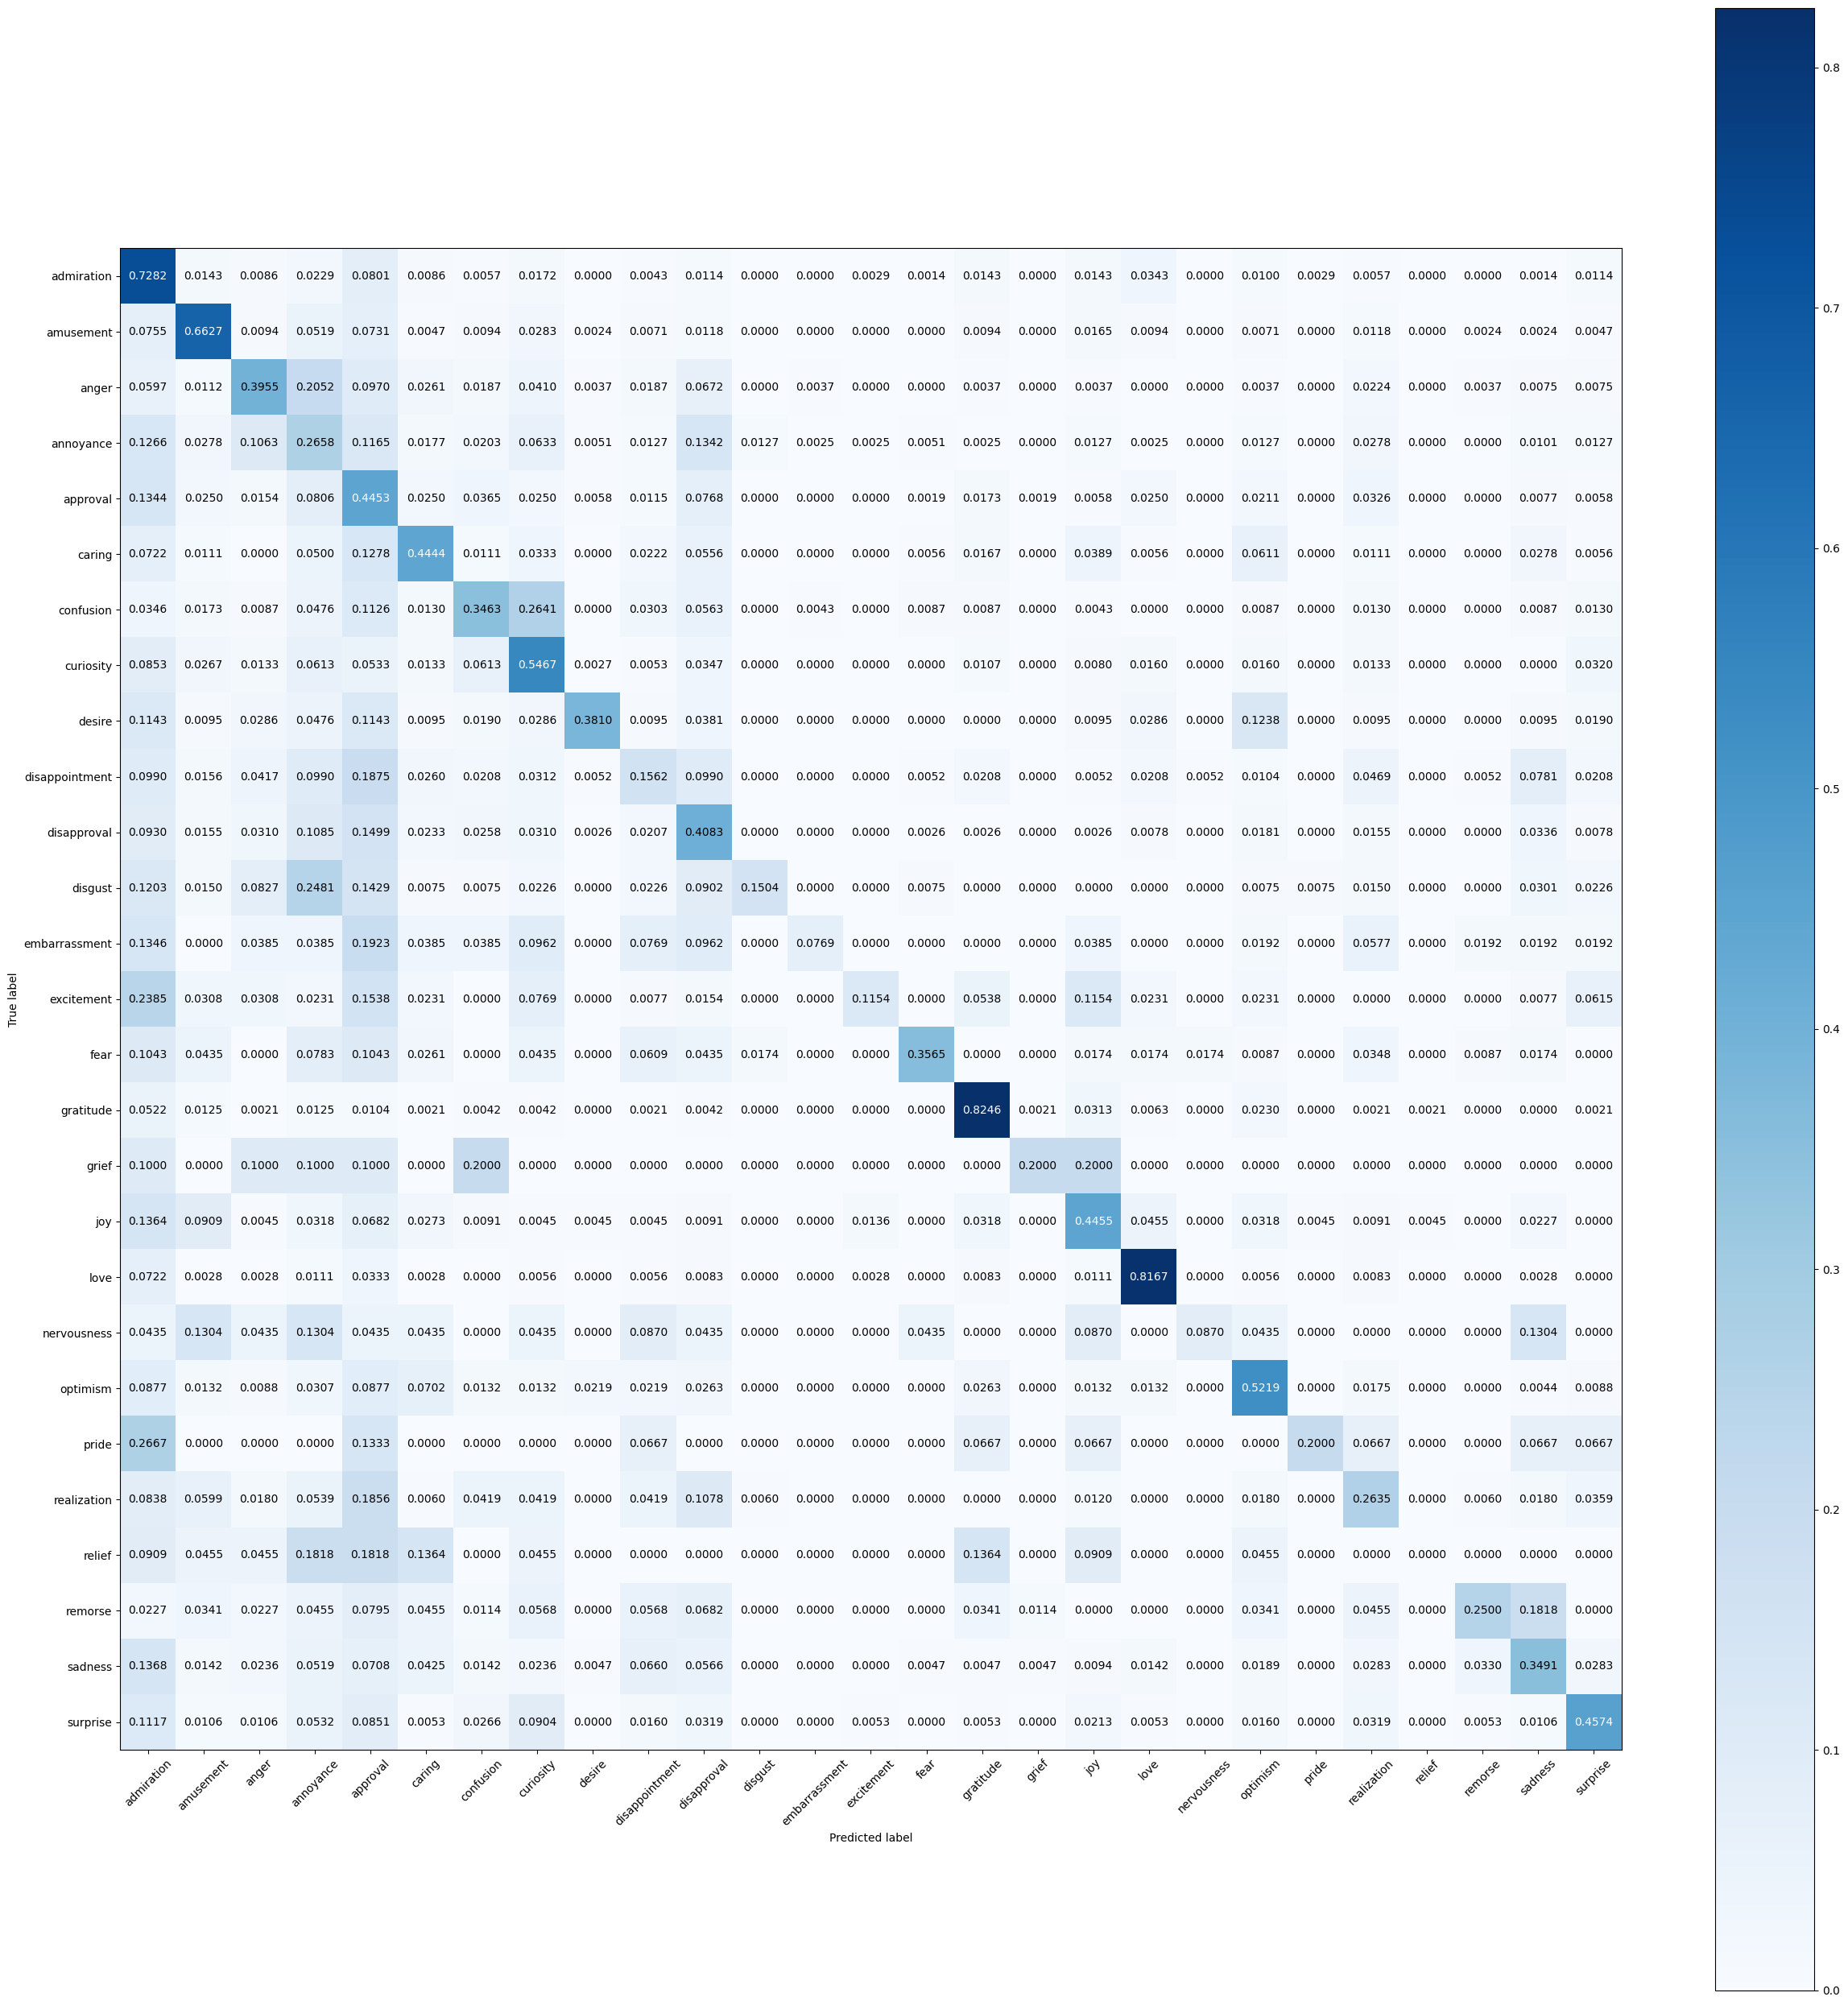

In [13]:
utils.plot_conf_mtrx_all(model, test_ds, classes)

1/1 [==============================] - 0s 260ms/step


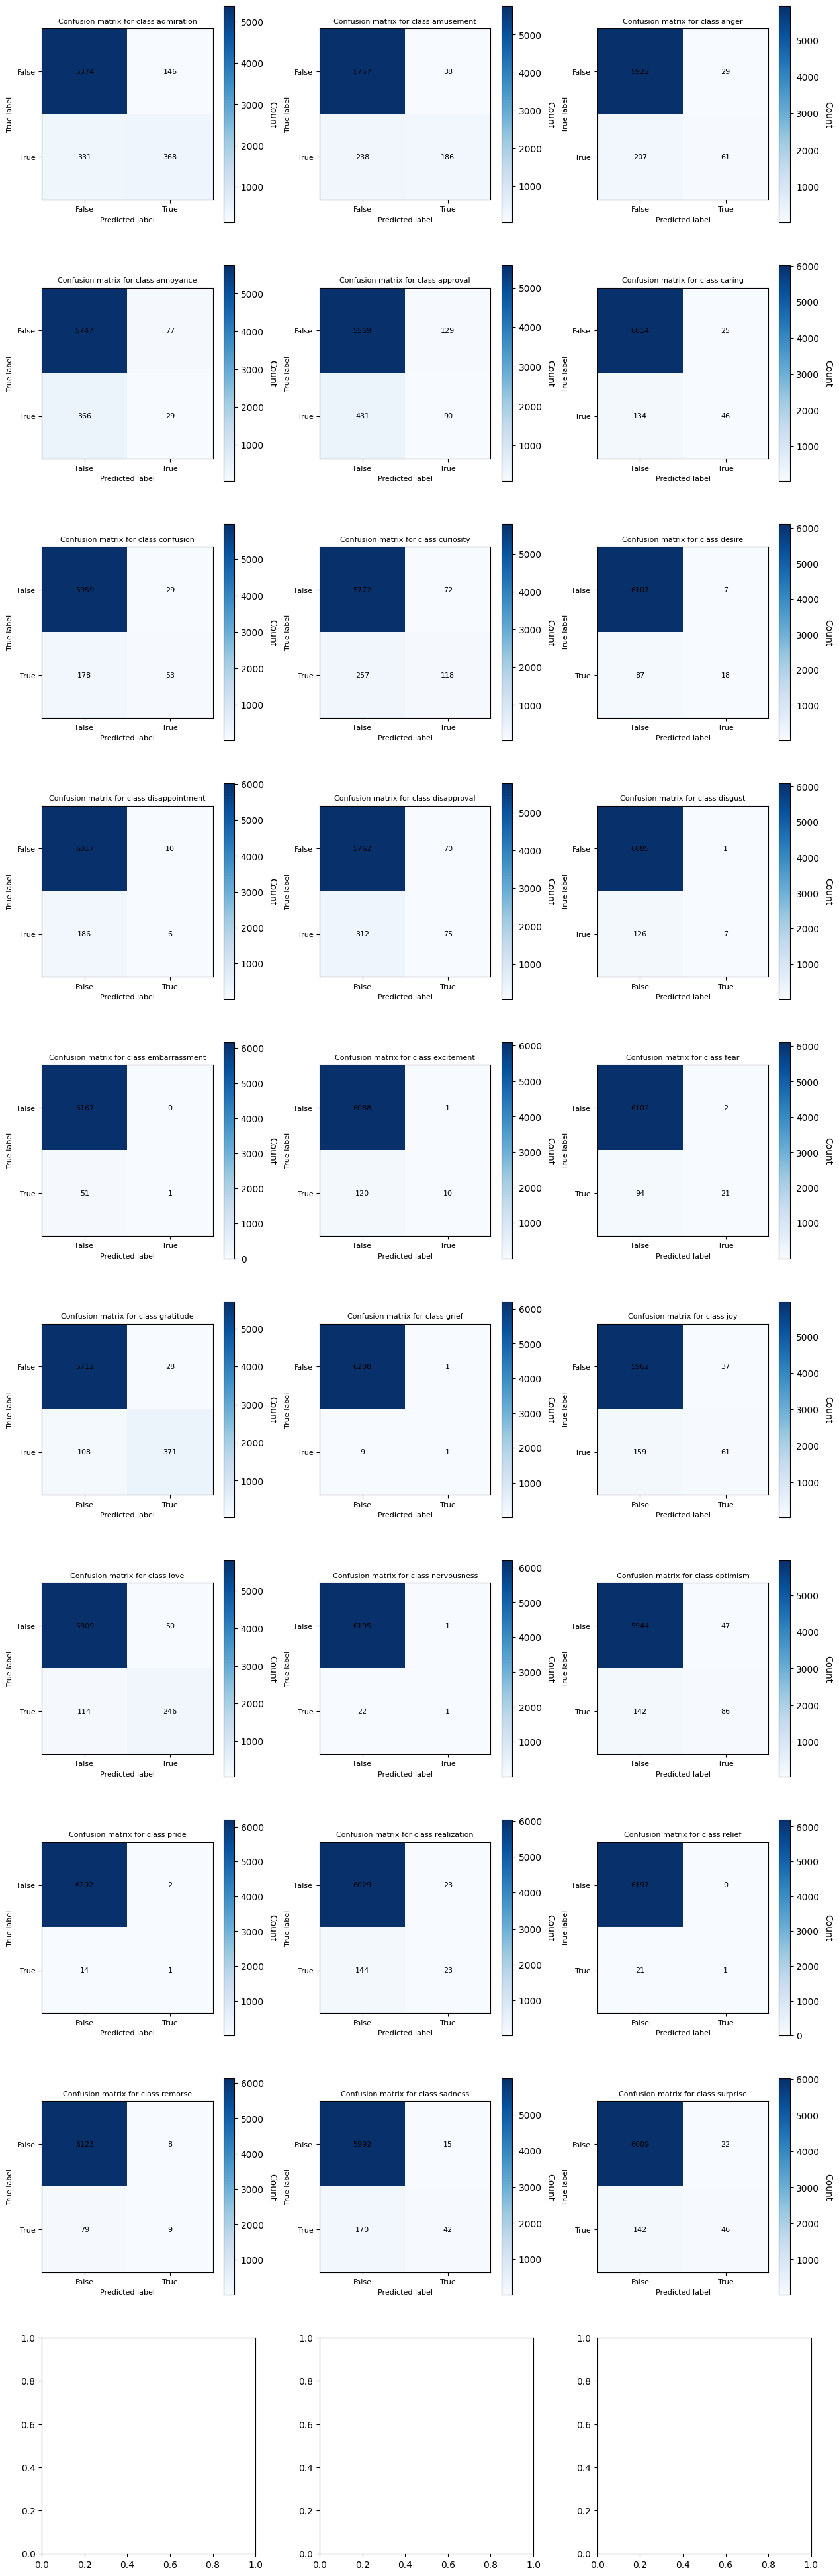

In [14]:
utils.plot_conf_mtrx_per_class(model, test_ds, classes)

In [ ]:
model.save_weights('./models/mlp_model')